# TP on Adversarial Bandits

**Brice TAYART**

---

*In the lecture, we saw the adversarial bandit framework as a game between a player and nature. In fact, there is a strong connexion between regret minimization and game theory. In this practical session, we will apply the EXP3 algorithm to a sequential two-player zero sum game.*

*We consider the sequential version of a two-player zero-sum games between a player and an adversary.*

---
 **Setting 1: Setting of a sequential two-player zero sum game**

*Let $L \in [-1,1]^{M\times N}$ be a loss matrix.*

 *At each round $t = 1,...,T$*
- *The player choose a distribution $p_y \in \Delta_M := \{p \in [0,1]^M ,\sum^M_{i=1} p_i=1\}$*
- *The adversary chooses a distribution $q_t \in \Delta_N$*
- *The actions of both players are sampled $i_t \sim p_t$ and $j_t \sim q_t$*
- *The player incurs the loss $L(i_t , j_t )$ and the adversary the loss $−L(i_t , j_t )$.*


### Question 1
*1. Define $M , N$ and a loss matrix $L \in [−1, 1]^{M\times N}$ that corresponds to the game “Rock paper scissors”.*

$M$ is the number of actions available to the player and $N$ the number of actions available to the adversary. In the case of "Rock, Paper, Scissors", there are three actions for both, i.e. $M=N=3$

**Let action 1 be Rock, action 2 be Paper, and action 3 be Scissors.** The loss matrix for the player is:

$$L = \left[
\begin{array}{ccc}
0 & 1 & -1\\
-1 & 0 & 1\\
1 & -1 & 0
\end{array}
\right]$$

e.g. if player plays Rock (1) and adversary plays Scissors (3), then the player wins and incurs a negative loss $L_{1,3}=-1$

---
## Full information feedback
*In this part, we assume that both players know the matrix $L$ in advance and can compute $L(i,j)$ for any $(i, j)$.*

### Question 2
*2. Implementation of EWA.*

*(a) In order to implement the exponential weight algorithm, you need a way to sample from the exponential weight distribution. Implement the function* **rand_exp** *that takes as input a probability vector $p \in \Delta_M$ and uses a single call to* **rand()** *to return $X \in [M]$ with $\mathbb P (X = i) = p_i$.*

*(b) Define a function* **EWA_update** *that takes as input a vector $p_t \in \Delta_M$ and a loss vector $t \in [−1,1]^M$ and
return the updated vector $p_{t+1} \in \Delta_M$ defined for all $i \in [M]$ by:*

$$p_{t+1}(i)=\frac{
p_t(i)\exp (-\eta l_t(i))
}{
\sum^M_ {j=1} p_t(j)\exp (-\eta l_t(j))
}
$$

---
Note: while the standard notation for indices is used for the theoretical answers (e.g. $i_t \in \{1,...,M\}$), the code will use standard Python indices (e.g. between 0 and M-1)



In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

# Set seed for reproductibility
np.random.seed(1234)

In [2]:
def rand_exp(proba_vector):
    # alternative one liner that does not call rand()
    #    return np.random.choice(np.array(proba_vector).size, size=None, p=proba_vector)

    # Compute cumulative probability
    cumulative_proba = np.array(proba_vector).cumsum()
    cumulative_proba /= cumulative_proba[-1]

    # Draw r randomly
    r = np.random.rand()

    # Return the first index such that r < cumulative probability
    return (r < cumulative_proba).nonzero()[0][0].astype('int')


def EWA_update(proba_vector, loss_vector, eta):
    ewa_vector = proba_vector * np.exp(-eta * loss_vector)
    return ewa_vector / ewa_vector.sum()

---
### Question 3
*3. Simulation against a fixed adversary. Consider the game “Rock paper scissors” and assume that the adversary chooses $q_t = (1/2, 1/4, 1/4)$ and samples $j_t \sim q_t$ for all rounds $t \ge 1$*

In order to run the simulations, that are repeated many times, with various strategies with as little copy/paste as possible, a Simulation class is built, as well as a Strategy class that will be derived into player strategies (fixed, EWA, EXP3, etc).

Most of the code for simulation, statistics, metrics, etc is concentrated here.

The algorithm for a simulation is:
- Initialize player strategies
- For each of *n_rounds* rounds:
    - Get an action from each player
    - Compute the loss for each player
    - Inform each player of the loss vector, given the other player action
    - Log all data from the round (actions taken, loss, and action probability profile)

In order to implement this, player strategies are contained within a **Strategy** object with the following methods:
- ***reset()*** : Reset the strategy at the beginning of a simulation (e.g. reset the action probability vector to equiprobability)
- ***get_action()*** : Draw an action based on the action probability vector
- ***get_proba()*** : Return the action probability vector (for logging)
- ***update(loss_vector, action_taken)*** : Update the  action probability vector knowing the full loss vector (given the other player action) after playing some action.

A specific **BanditStrategy** subclass is implemented, where all elements in the loss vector but the one corresponding to the action played are discarded. The loss is then passed to a method:
- ***_bandit_update(loss, action_taken)*** : Update the action probability vector given the loss incurred after playing some action.

In general, only the ***\_\_init__***, ***reset***, and ***update*** or ***_bandit_update*** should be overloaded. 

In [3]:
class Simulation:
    """Class used to simulate a game between two player"""

    def __init__(self, player1_strategy, player2_strategy, loss_matrix1, loss_matrix2=None):
        """Set the game parameters"""
        self.L1 = loss_matrix1
        
        # zero-sum game
        if loss_matrix2 is None:
            self.L2 = -self.L1
        else:
            self.L2 = loss_matrix2

        self.M = self.L1.shape[0]
        self.N = self.L1.shape[1]

        self.strategy_1 = player1_strategy
        self.strategy_2 = player2_strategy

    def simulate(self, n_rounds):
        # Init arrays where probabilities, losses and actions will be logged
        self.n_rounds = n_rounds

        self.log_pt = np.zeros((n_rounds, self.M))
        self.log_qt = np.zeros((n_rounds, self.N))
        self.log_it = np.zeros((n_rounds,), dtype='int')
        self.log_jt = np.zeros((n_rounds,), dtype='int')
        self.log_lt1 = np.zeros((n_rounds,))
        self.log_lt2 = np.zeros((n_rounds,))

        # initialize player strategies
        self.strategy_1.reset()
        self.strategy_2.reset()

        for this_round in range(n_rounds):
            # pick and log player actions
            it = self.strategy_1.get_action()
            jt = self.strategy_2.get_action()
            self.log_it[this_round] = it
            self.log_jt[this_round] = jt

            # log loss
            self.log_lt1[this_round] = self.L1[it, jt]
            self.log_lt2[this_round] = self.L2[it, jt]

            # update strategies
            # L1[:,jt] is the loss vector for actions of player 1 (given player 2 action)
            # L2[it,:] is the loss vector for actions of player 2 (given player 2 action)
            self.strategy_1.update(self.L1[:, jt], it)
            self.strategy_2.update(self.L2[it, :], jt)

            # log action probabilities
            self.log_pt[this_round, :] = self.strategy_1.get_proba()
            self.log_qt[this_round, :] = self.strategy_2.get_proba()

    #####
    # Below are methods to compute statictics from the simulation results:
    # All return vectors of lenght (n_rounds) except mean_pt & mean_qt that
    # return matrices of size (n_rounds, M)
    #####

    # Average loss (average cumulative loss over time)
    def mean_loss_1(self):
        return self.log_lt1.cumsum() / (1+np.arange(self.n_rounds))

    def mean_loss_2(self):
        return self.log_lt2.cumsum() / (1+np.arange(self.n_rounds))

    # Expected loss if players use strategies p_t and q_t
    # this is a vector with, for each t, the expected loss p_t L q_t
    def exp_loss_1(self):
        return ((self.log_pt@self.L1)*self.log_qt).sum(axis=1)

    def exp_loss_2(self):
        return (self.log_pt*(self.L2@self.log_qt)).sum(axis=1)

    # Average strategies (average of all strategies over time)
    def mean_pt(self):
        return self.log_pt.cumsum(axis=0) / (1+np.arange(self.n_rounds)).reshape(-1, 1)

    def mean_qt(self):
        return self.log_qt.cumsum(axis=0) / (1+np.arange(self.n_rounds)).reshape(-1, 1)

    # Cumuative loss
    def cumul_loss_1(self):
        return self.log_lt1.cumsum()

    def cumul_loss_2(self):
        return self.log_lt2.cumsum()

    # Optimal strategy, regret
    def optimal_loss_1(self):
        # Compute, for each pure strategy i, the cumulative loss if player 2 had
        # been playing j_t at each round
        # The optimal loss is cumulative loss for the best strategy i
        return self.L1[:, self.log_jt].cumsum(axis=1).min(axis=0)

    def optimal_loss_2(self):
        return self.L2[self.log_it, :].cumsum(axis=0).min(axis=1)

    def cumul_regret_1(self):
        return self.cumul_loss_1() - self.optimal_loss_1()

    def cumul_regret_2(self):
        return self.cumul_loss_2() - self.optimal_loss_2()

Below is the implementation of the generic templates for full information and bandit strategies:

In [4]:
class Strategy:
    """Template for strategies, which simulates a constant, mixed strategy"""

    def __init__(self, proba=[1]):
        self.proba = np.array(proba)

    def reset(self):
        """Re-initialize in order to run a new simulation"""
        pass

    def get_action(self):
        """Return the next action"""
        return rand_exp(self.proba)

    def get_proba(self):
        """Return current probability distribution for next action"""
        return self.proba

    def update(self, loss_vector, my_action):
        """Overload if the strategy is updated after the loss is known"""
        pass


class BanditStrategy(Strategy):
    """Template for Bandit strategies (the full loss vector is not known)"""

    def update(self, loss_vector, my_action):
        self._bandit_update(loss_vector[my_action], my_action)

    def _bandit_update(self, loss, my_action):
        """Overload if the strategy is updated after the loss is known"""
        pass

In [5]:
class EWAStrategy(Strategy):
    """EWA strategy with parameter eta"""

    def __init__(self, eta: float, n_actions: int):
        self.eta = eta
        self.N = n_actions
        self.reset()

    def reset(self):
        """Reset vector p to equiprobability"""
        self.proba = np.ones(self.N)/self.N

    def update(self, loss_vector, my_action):
        self.proba = EWA_update(self.proba, loss_vector, self.eta)

*(a) What is the loss $l_t(i)$ incurred by the player if he chooses action $i$ at time $t$? Simulate an instance of the game for $t = 1,...,T = 100$ for $\eta = 1$.*

---
If player 1 plays action $i$, it will incur a loss $L_{i,j}, j \in {1...N}$ with probability $q_j$, i.e. its expected loss is $\mathbb E[l_t(i)] = \sum^N_{j=1} \mathbf{q}_t(j)L_{i,j} = <L_{i,\cdot},\mathbf{q}_t>$

The expected loss at round $t$ if player 1 samples its action $i_t$ from probability vector $\mathbf{p}_t$ is:
$\mathbb E[l_t] = \mathbf{p}_t^T L \mathbf{q}_t$

In [6]:
# Init the game
L = np.array([[0, 1, -1], [-1, 0, 1], [1, -1, 0]])
M, N = L.shape
actions = ['Rock', 'Paper', 'Scissors']
n_rounds = 100

# player 1 strategy
eta = 1
# player 2 strategy
q_t = np.array([.5, .25, .25])

# Run simulation
sim = Simulation(EWAStrategy(eta, M), Strategy(q_t), L)
sim.simulate(n_rounds)

*(b) Plot the evolution of the weight vectors $p_1, p_2,...,p_T$. What seems to be the best strategy against this adversary?*

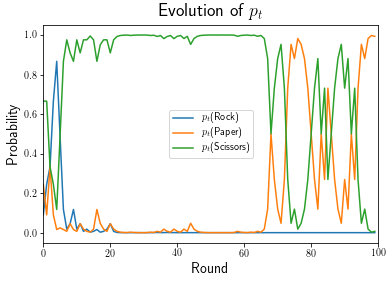

In [7]:
# Plot p_t
for ii in range(sim.log_pt.shape[1]):
    plt.plot(sim.log_pt[:, ii], label='$p_t$({})'.format(actions[ii]))

plt.xlabel("Round", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.title("Evolution of $p_t$", fontsize=18)
plt.ylim(-.05, 1.05)
plt.xlim(0, n_rounds);

The strategy eventually converges to picking **Paper** with probability 1, which is the strategy that gives the lowest expected loss with an adversary that plays **Rock** most often (loss -1) or otherwise **Paper** or **Scissors** with equal probability (loss 0 and 1). This is the dominant strategy for Player 1, given Player 2 strategy.

This is an outlier, convergence happens after fewer rounds usually, as shown in the second run of the simulation below:

In [8]:
sim.simulate(n_rounds)

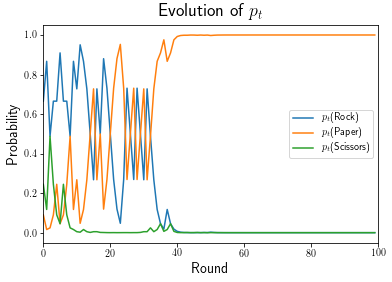

In [9]:
# Plot p_t
for ii in range(sim.log_pt.shape[1]):
    plt.plot(sim.log_pt[:, ii], label='$p_t$({})'.format(actions[ii]))

plt.xlabel("Round", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.title("Evolution of $p_t$", fontsize=18)
plt.ylim(-.05, 1.05)
plt.xlim(0, n_rounds);

*(c) Plot the average loss $\bar{l_t} = \frac{1}{t} \sum^t_{s=1} l(i_s,j_s)$ as a function of $t$.*

The plot below shows, as a function of rouns $t$, the evolution of the average loss $\bar{l_t}$ incurred at a given round. It also shows the expected loss of policy $\mathbf{p}_t$ vs policy $\mathbf{q}_t$.

Once Player 1 has settled for a pure **Paper** strategy, its expected loss settles to $-0.25$ and the mean loss $\bar{l_t}$ slowly converge to that value, as per the law of great numbers

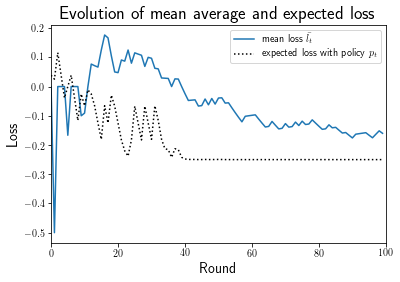

In [10]:
# plot l_bar
plt.plot(sim.mean_loss_1(), label='mean loss $\\bar{l_t}$')
plt.plot(sim.exp_loss_1(), ':k', label='expected loss with policy $p_t$')
plt.legend()

plt.xlabel('Round', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xlim(0, n_rounds)
plt.title('Evolution of mean average and expected loss', fontsize=18);

*(d) Plot the cumulative regret.*

---
To measure regret at each round, we take the cumulative sum of the loss vector based on player 2 actions. This gives the cumulative loss that player 1 would have incurred by playing a pure strategy. The minimum among the strategies is the optimal loss for the round. See *Simulation.cumul_regret_1()* method

Once Player 1 has settled for the pure **Paper** strategy, regret does not evolve. Even though is the player occasionally loses, he still follows the optimal pure strategy (i.e. at each round, the player incurs the same loss as the optimal strategy).

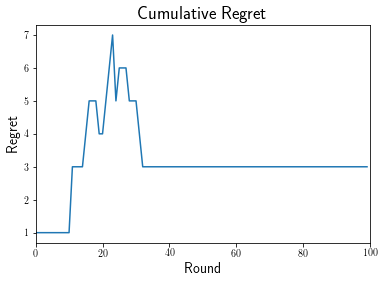

In [11]:
# Plot regret
plt.plot(sim.cumul_regret_1())
plt.xlabel('Round', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.xlim(0, n_rounds)
plt.title('Cumulative Regret', fontsize=18);

*(e) To see if the algorithm is stable, repeat the simulation $n = 10$ times and plot the average loss $(\bar{l_t})_{t \ge 1}$ obtained in average, in maximum and in minimum over the n simulations.*

In [12]:
# Repeat 10 simulations and store the loss
n_rpt = 10
mean_loss = np.zeros((n_rounds, n_rpt))

for rpt in range(n_rpt):
    sim.simulate(n_rounds)
    mean_loss[:, rpt] = sim.mean_loss_1()

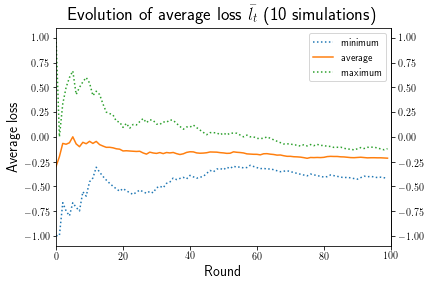

In [13]:
# Plot min/average/max l_bar
plt.plot(mean_loss.min(axis=1), ':', label='minimum')
plt.plot(mean_loss.mean(axis=1), label='average')
plt.plot(mean_loss.max(axis=1), ':', label='maximum')

plt.xlabel('Round', fontsize=14)
plt.ylabel('Average loss', fontsize=14)
plt.xlim(0, n_rounds)
plt.legend()
plt.title(
    'Evolution of average loss $\\bar{l_t}$ (10 simulations)', fontsize=18)
plt.gca().secondary_yaxis('right');

For all simulations, the average loss $\bar{l_t}$ ends up close to -0.25 after 100 rounds. $\bar{l_t}$ doesn't have much variance at that point.

Convergence to another strategy than the optimal one would give an expected value of $\bar{l_t}$ close to 0.0 (for **Rock**) or 0.25 (for **Scissors**)

---
*(f) Repeat one simulation for different values of learning rates $\eta \in \{0.01, 0.05, 0.1, 0.5, 1\}$ and plot the final
regret as a function of $\eta$. What are the best $\eta$ in practice and in theory?*

In order to improve the repeatability, player 2 will always take the same actions drawn according to strategy $q_t$, across all simulations with varying $\eta$.

In [14]:
class RepeatableStrategy(Strategy):
    """
    This is a strategy with constant, mixed probabilities
    The actions that are drawn are stored so that the strategy can be
    repeated in several simulations and always give the same results
    """

    def __init__(self, proba=[1]):
        self.proba = np.array(proba)
        self.drawn_actions = [rand_exp(self.proba)]
        self.iteration = 0

    def reset(self):
        self.iteration = 0

    def get_action(self):
        return self.drawn_actions[self.iteration]

    def update(self, loss_vector, my_action):
        """If needed, draw and store the next action to be played"""
        self.iteration += 1
        if self.iteration >= len(self.drawn_actions):
            self.drawn_actions.append(rand_exp(self.proba))

In [15]:
# Run several simulations with various eta

#all_eta = [0.01, 0.05, 0.1, 0.5, 1]
all_eta = [ii/100 for ii in range(10)] + [ii/10 for ii in range(1, 10)] + [
    ii for ii in range(1, 11)] + [20, 30]
n_rounds = 100

final_regret = np.zeros(len(all_eta))

# The object will be re-used across simulations so that player 2 always plays the same actions
rpt_strategy = RepeatableStrategy(q_t)

for n_sim, eta in enumerate(all_eta):
    sim = Simulation(EWAStrategy(eta, M), rpt_strategy, L)
    sim.simulate(n_rounds)
    final_regret[n_sim] = sim.cumul_regret_1()[-1]

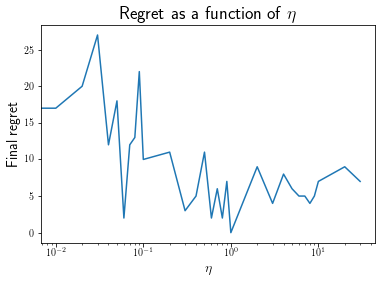

In [16]:
# Plot the regret

plt.semilogx(all_eta, final_regret)
plt.xlabel('$\eta$', fontsize=14)
plt.ylabel('Final regret', fontsize=14)
plt.title('Regret as a function of $\\eta$', fontsize=18);

In [17]:
# optimal eta
np.sqrt(np.log(M)/n_rounds)

0.1048147073968205

The optimal value for $\eta$ is given by $\eta = \sqrt{\frac{\log(M)}{T}} = 0.105$. This is optimal value in order to minimize **an upper bound** to the expected regret after $T$ rounds, without making any assumptions on the loss vectors $l_t$ at each round. There is no reason, however, that this choice of $\eta$ is the optimal choice in any specific case, in particular when the loss vector is constant: it is a minimizer of the upper bound, not a minimizer of the expected regret (which depends the distribution of $l_t$).

In this example, it seems that there is a trend, where an increase in $\eta$ results in a decrease of the final regret and a reduction in its variance. The choice of $\eta=1$ seems fine, with a low regret and low variance. This trend seems confirmed when more simulations are done, with a low and stable regret for $\eta$ between 1 and 10.

In [18]:
# Run several simulation

# Do it again with several simulations:

n_rpt = 50
final_regret = np.zeros((len(all_eta), n_rpt))

for rpt in range(n_rpt):
    # Player 2 plays the same for each eta of one batch of simulations
    rpt_strategy = RepeatableStrategy(q_t)

    for n_sim, eta in enumerate(all_eta):
        sim = Simulation(EWAStrategy(eta, M), rpt_strategy, L)
        sim.simulate(n_rounds)
        final_regret[n_sim, rpt] = sim.cumul_regret_1()[-1]

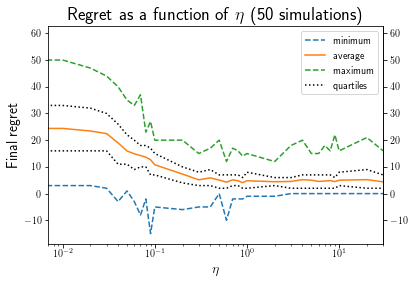

In [19]:
# Plot final regret: min/max/average and quartiles

final_regret.sort(axis=1)
plt.semilogx(all_eta, final_regret[:, 0], '--', label='minimum')
plt.semilogx(all_eta, final_regret.mean(axis=1), label='average')
plt.semilogx(all_eta, final_regret[:, -1], '--', label='maximum')
plt.semilogx(all_eta, final_regret[:, np.floor(
    n_rpt/4).astype('int')], ':k', label='quartiles')
plt.legend()
plt.semilogx(all_eta, final_regret[:, np.ceil(3*n_rpt/4).astype('int')], ':k')


plt.xlabel('$\eta$', fontsize=14)
plt.ylabel('Final regret', fontsize=14)
plt.gca().secondary_yaxis('right')
plt.title('Regret as a function of $\\eta$ (%d simulations)' %
          n_rpt, fontsize=18)
plt.xlim(all_eta[1]*.7,all_eta[-1]);

In most of the cases, the regret is very low, around 5: this is the expected regret for 20 round with a draw strategy (+.25/round) or 10 rounds with a losing strategy (+.50 per round). The algorithm generally converges quicly towards the optimal solution.

---
### Question 4
*4. Simulation against an adaptive adversary. Repeat the simulation of question 3) when the adversary is also playing EWA with learning parameters $\eta = 0.05$.*

*(a) Plot $\frac{1}{t} \sum^t_{s=1}l(i_s , j_s)$ as a function of $t$.*

*It is possible to show that if both players play according to a regret minimizing strategy the cumulative loss of the player converges to the value of the game:*
$$V = \min_{p \in \Delta_M} \max_{q \in \Delta_N} p^TLq$$

In [20]:
# Simulate two EWA strategies one agains each other
n_rounds = 2000
eta_1 = 1
eta_2 = .05

sim = Simulation(EWAStrategy(eta_1, M), EWAStrategy(eta_2, N), L)
sim.simulate(n_rounds)

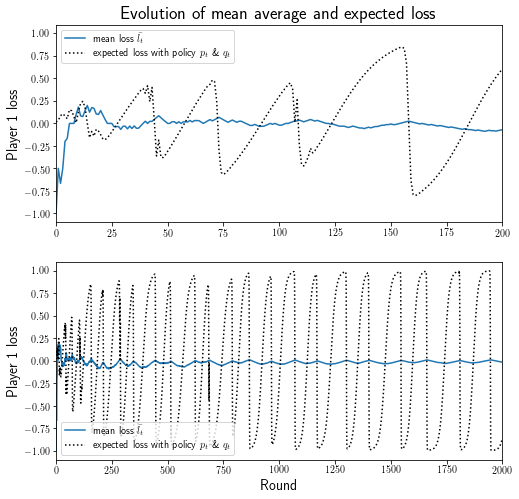

In [21]:
plt.figure(figsize = (8,8))

# Plot l_bar (zomm on 200 first rounds)
plt.subplot(2,1,1)
plt.plot(sim.mean_loss_1(), label='mean loss $\\bar{l_t}$')
plt.plot(sim.exp_loss_1(), ':k',
         label='expected loss with policy $p_t$ \& $q_t$')
plt.legend()

plt.ylabel('Player 1 loss', fontsize=14)
plt.xlim(0, 200)
plt.title('Evolution of mean average and expected loss', fontsize=18)

# Plot l_bar (zomm on 200 first rounds)
plt.subplot(2,1,2)
plt.plot(sim.mean_loss_1(), label='mean loss $\\bar{l_t}$')
plt.plot(sim.exp_loss_1(), ':k',
         label='expected loss with policy $p_t$ \& $q_t$')
plt.legend()

plt.xlabel('Round', fontsize=14)
plt.ylabel('Player 1 loss', fontsize=14)
plt.xlim(0, n_rounds);


What we see is that the average loss quickly converges towards zero. As both player adapt to each other in this zero-sum game, their strategies neutralize each other and they get no loss on average.

When looking at the expected loss based on current strategies at round $t$, we can observe large oscillations.  This is due to the different learning rates. Player 1, a quick learner, will adopt a strategy that beats player 2 on average. Over time, and while player 1 accumulates gains, player 2 will adapt and choose a strategy that beats player 1: the expected loss for player 1 slowly becomes positive. However, player 1 will not change its strategy until all the gains accumulated have been lost and another strategy is chosen. As player 1 once again beats player 2, the expected loss suddenly becomes negative, starting a new oscillation. 

**This same behavior will be observed for all algorithms that rely on accumulated rewards like EXP3, UCB** , etc : the longer a strategy have been working against an oppenent, the larger the cumulated reward it has given. If the adversary adapts so that it becomes a losing strategy, then it will take an equally long time for the accumulated rewards to vanish and the player to adapt its strategy to the adversary.

This is seen in the evolution of the strategies over time, plotted below:

(-0.05, 1.05)

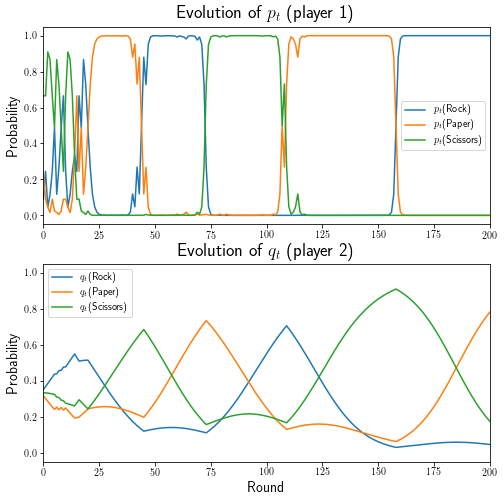

In [22]:
# Plot strategies p_t and q_t

plt.figure(figsize=(8, 8))

# Player 1
plt.subplot(2, 1, 1)
for ii in range(M):
    plt.plot(sim.log_pt[:, ii], label='$p_t$({})'.format(actions[ii]))

# plt.xlabel("Round",fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.title("Evolution of $p_t$ (player 1)", fontsize=18)
plt.xlim(0, 200)
plt.ylim(-.05, 1.05)

# Player 2
plt.subplot(2, 1, 2)
for ii in range(M):
    plt.plot(sim.log_qt[:, ii], label='$q_t$({})'.format(actions[ii]))

plt.xlabel("Round", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.title("Evolution of $q_t$ (player 2)", fontsize=18)
plt.xlim(0, 200)
plt.ylim(-.05, 1.05)

*(b) Define $\bar{p_t} = \frac{1}{t}\sum_{s=1}p_s$. Plot in log log scale $\Vert \bar{p_t} - (1/3, 1/3, 1/3)\Vert_2$ as a function of $t$.*

*It is possible to show that $(\bar{p_t}, \bar{q_t})_{t\ge1}$ converges almost surely to a Nash equilibrium of the game. This means that if $p \times q$ is a Nash equilibrium, none of the players should change is strategy if the other player does not change hers.*

---
Below are 4 plot with the evolution of average strategies $\bar{p_t}$ and $\bar{q_t}$, and distances to equilibrium $\Vert \bar{p_t} - (1/3, 1/3, 1/3)\Vert_2$ and $\Vert \bar{q_t} - (1/3, 1/3, 1/3)\Vert_2$.

It seems that, on the log-log plot, there is some linear upper bound to the distance between $\bar{p_t}$ and the Nash equilibrium, i.e. that $\bar{p_t}$ has an exponential convergence towards the equilibrium. The same is visible for $\bar{q_t}$, although the convergence seems slower. It is hard to draw conclusions from a single simulation, though.

(1, 2000)

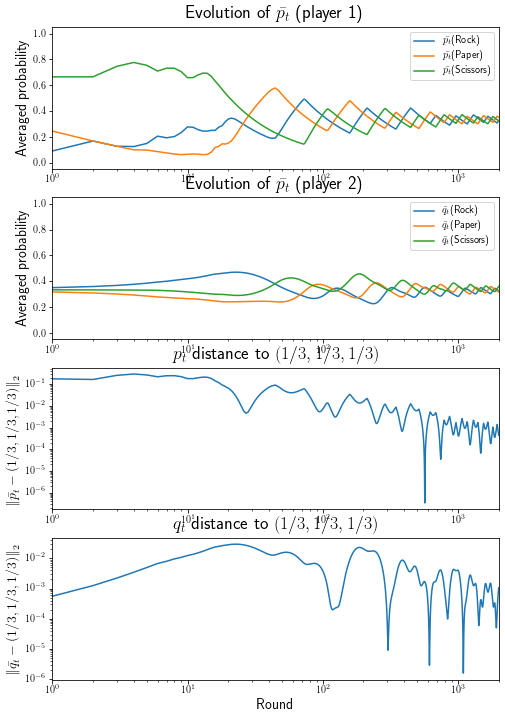

In [23]:
# Plot p_bar and q_bar
# Plot their distance to the Nash equilibrium

plt.figure(figsize=(8, 12))

p_bar = sim.mean_pt()
q_bar = sim.mean_qt()
p_dist = ((p_bar - np.ones((1, 3))/3)**2).sum(axis=1)
q_dist = ((q_bar - np.ones((1, 3))/3)**2).sum(axis=1)

# Evolution of p_bar
plt.subplot(4, 1, 1)
for ii in range(p_bar.shape[1]):
    plt.semilogx(1+np.arange(n_rounds),
                 p_bar[:, ii],
                 label='$\\bar{p_t}$(%s)' % format(actions[ii]))

# plt.xlabel("Round",fontsize=14)
plt.ylabel("Averaged probability", fontsize=14)
plt.legend()
plt.title("Evolution of $\\bar{p_t}$ (player 1)", fontsize=18)
plt.xlim(1, n_rounds)
plt.ylim(-.05, 1.05)

# Evolution of q_bar
plt.subplot(4, 1, 2)
for ii in range(q_bar.shape[1]):
    plt.semilogx(1+np.arange(n_rounds),
                 q_bar[:, ii],
                 label='$\\bar{q_t}$(%s)' % format(actions[ii]))

# plt.xlabel("Round",fontsize=14)
plt.ylabel("Averaged probability", fontsize=14)
plt.legend()
plt.title("Evolution of $\\bar{p_t}$ (player 2)", fontsize=18)
plt.xlim(1, n_rounds)
plt.ylim(-.05, 1.05)

# Evolution of p_dist
plt.subplot(4, 1, 3)
plt.loglog(1+np.arange(n_rounds), p_dist)

# plt.xlabel("Round",fontsize=14)
plt.ylabel("$\\Vert \\bar{p_t} - (1/3, 1/3, 1/3)\\Vert_2$", fontsize=14)
plt.title("$p_t$ distance to $(1/3,1/3,1/3)$", fontsize=18)
plt.xlim(1, n_rounds)

# Evolution of q_dist
plt.subplot(4, 1, 4)
plt.loglog(1+np.arange(n_rounds), q_dist)

plt.xlabel("Round", fontsize=14)
plt.ylabel("$\\Vert \\bar{q_t} - (1/3, 1/3, 1/3)\\Vert_2$", fontsize=14)
plt.title("$q_t$ distance to $(1/3,1/3,1/3)$", fontsize=18)
plt.xlim(1, n_rounds)

---
## Bandit feedback
*Now, we assume that the players do not know the game in advance but only observe the performance $L(i_t, j_t)$ (that we assume here to be in $[0, 1]$) of the actions played at time $t$. They need to learn the game and adapt to the adversary as one goes along.*

---
### Question 5
*5. Implementation of **EXP3**. Since both players are symmetric, we focus on the first player.*

*(a) Implement the function* **estimated_loss** *that takes as input the action $i_t \in [M]$ played at round $t \ge 1$ and the loss $L(i_t, j_t)$ suffered by the player and return the vector of estimated loss $\hat{l_t} \in \mathbb{R}^M_+$ used by **EXP3**.*

*(b) Implement the function* **EXP3_update** *that takes as input a vector $p_t \in \Delta_M$ , the action $i_t \in [M]$ played by the player and the loss $L(i_t,j_t)$ and return the updated weight vector $p_{t+1} \in \Delta_M$.*

The **EXP3** strategy is implemented below. The strategy needs the loss to be in range $[0,1]$. Since the loss matrix has values in range $[-1,1]$, an affine transformation is applied within the EXP3Strategy._update_bandit()* method

The class implements both **EXP3** and **EXP3.IX** strategies, the former being a specific case ot the latter with the regularization factor $\gamma$ set to zero.

In [24]:
def estimated_loss(action_probability, loss, action, N):
    """Builds a vector of zeros, with only index 'action'
    filled with estimated loss l_t(k)/p_t(k)"""
    loss_vec = np.zeros(N)
    loss_vec[action] = loss/action_probability
    return loss_vec


def EXP3_update(proba, loss, action, eta):
    est_loss = estimated_loss(proba[action], loss, action, proba.size)
    # Re-use EWA_update with the estimated loss
    return EWA_update(proba, est_loss, eta)


def EXP3IX_update(proba, loss, action, eta, gamma=0.0):
    # Same as EXP3_update with some regularization
    est_loss = estimated_loss(proba[action]+gamma, loss, action, proba.size)
    return EWA_update(proba, est_loss, eta)


class EXP3Strategy(BanditStrategy):
    """
    Implements EXP3 strategy and EXP3.IX strategy
    EXP3Strategy(eta,nb_actions) --> EXP3 algorithm
    EXP3Strategy(eta,nb_actions, gamma) --> EXP3.IX algorithm 
    """

    def __init__(self, eta: float, n_actions: int, gamma: float = 0.0):
        self.eta = eta
        self.N = n_actions
        self.gamma = gamma
        self.reset()

    def reset(self):
        self.proba = np.ones(self.N)/self.N

    def _bandit_update(self, loss, my_action):
        # Start with an affine transformation [-1,1] --> [0,1]
        loss = .5*loss + .5
        self.proba = EXP3IX_update(
            self.proba, loss, my_action, self.eta, self.gamma)


---
*6. Simulation against a fixed adversary. Consider the game “Rock paper scissors” and assume that the adversary chooses $q_t = (1/2, 1/4, 1/4)$ and samples $j_t \sim q_t$ for all rounds $t \ge 1$*

*(a) What is the loss $l_t(i)$ incurred by the player if he chooses action $i$ at time $t$? Simulate an instance of the game for $t = 1,...,T = 100$ for $\eta = 1$.*

*(b) Plot the evolution of the weight vectors $p_1, p_2,...,p_T$. What seems to be the best strategy against this adversary?*

In [25]:
# Init Rock, Paper, Scissors
L = np.array([[0, 1, -1], [-1, 0, 1], [1, -1, 0]])
M, N = L.shape
actions = ['Rock', 'Paper', 'Scissors']
n_rounds = 300

# player 1 strategy
eta = 1
# player 2 strategy
q_t = np.array([.5, .25, .25])


sim = Simulation(EXP3Strategy(eta, M), Strategy(q_t), L)
sim.simulate(n_rounds)

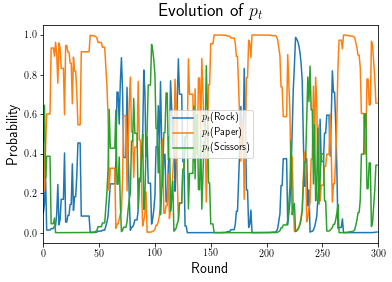

In [26]:
for ii in range(sim.log_pt.shape[1]):
    plt.plot(sim.log_pt[:, ii], label='$p_t$({})'.format(actions[ii]))

plt.xlabel("Round", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.title("Evolution of $p_t$", fontsize=18)
plt.xlim(0, n_rounds)
plt.ylim(-.05, 1.05);

The EXP strategy with $\eta=1$ fails to convege, although is seems to use the pure **Rock** strategy more than others. Another simulation is done below to seem if this is a stochastic effect.

In [27]:
sim.simulate(n_rounds)

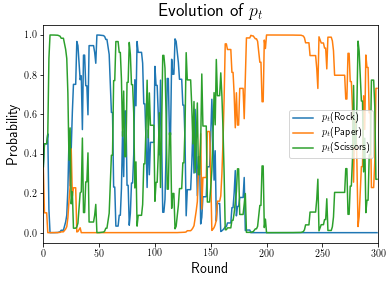

In [28]:
for ii in range(sim.log_pt.shape[1]):
    plt.plot(sim.log_pt[:, ii], label='$p_t$({})'.format(actions[ii]))

plt.xlabel("Round", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.title("Evolution of $p_t$", fontsize=18)
plt.xlim(0, n_rounds)
plt.ylim(-.05, 1.05);

With the second simulation, player 1 eventually picked the optimal **Paper** strategy after a while, but than starting to oscillate towards **Scissors**. Convergence did not occur within the simulation time.

Since the **EXP3** algorithm tends to give fast oscillations, a third simulation is performed with a smaller learning rate $\eta = 0.05$ in order to dampen oscillations and stabilize learning.

In [29]:
eta = .05
sim = Simulation(EXP3Strategy(eta, M), Strategy(q_t), L)
sim.simulate(n_rounds)

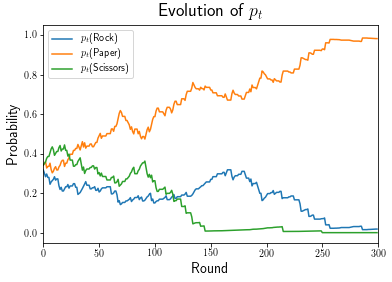

In [30]:
for ii in range(sim.log_pt.shape[1]):
    plt.plot(sim.log_pt[:, ii], label='$p_t$({})'.format(actions[ii]))

plt.xlabel("Round", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.title("Evolution of $p_t$", fontsize=18)
plt.xlim(0, n_rounds)
plt.ylim(-.05, 1.05);

This time, the algorithm has converged towards the optimal strategy. The time needed for that, around 300 rounds, is much higher than with **EWA** where it typically took 20-30 rounds.

---
*(c) Plot the average loss $\bar{l_t} = \frac{1}{t} \sum^t_{s=1} l(i_s,j_s)$ as a function of $t$.*

The plot below shows, as a function of rouns  𝑡 , the evolution of the average loss  𝑙𝑡¯  incurred at a given round. It also shows the expected loss of policy  𝐩𝑡  vs policy  𝐪𝑡 .

The plot below shows, as a function of rouns $t$, the evolution of the average loss $\bar{l_t}$ incurred at a given round. It also shows the expected loss of policy $\mathbf{p}_t$ vs policy $\mathbf{q}_t$.

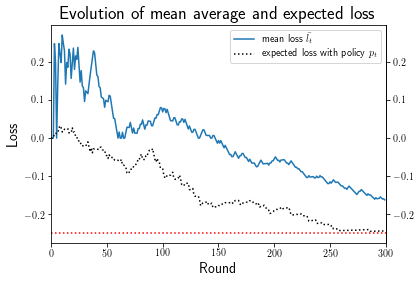

In [31]:
plt.plot(sim.mean_loss_1(), label='mean loss $\\bar{l_t}$')
plt.plot(sim.exp_loss_1(), ':k', label='expected loss with policy $p_t$')
plt.legend()
plt.plot([0, n_rounds], [-.25, -.25], ':r')

plt.xlabel('Round', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xlim(0, n_rounds)
plt.title('Evolution of mean average and expected loss', fontsize=18)
plt.gca().secondary_yaxis('right');

We see the expected loss slowly decrese towards the optimal value -0.25. The mean loss is also slowly converging towards this value, although convergence has not been achieved by the end of  the simulation.

---
*(d) Plot the cumulative regret.*

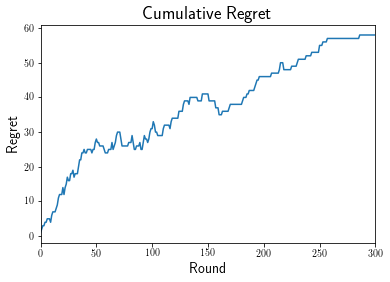

In [32]:
plt.plot(sim.cumul_regret_1())
plt.xlabel('Round', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.xlim(0, n_rounds)
plt.title('Cumulative Regret', fontsize=18);

Regret increases steadily as the algorithm takes time to find the optimal strategy, then stabilizes around 60. This is much higher than what was typically achieved with the **EWA** algorithm. This is expected, though: less information is available to the agorithm, and optimality can only be sought through exploration, which generates regret.

*(e) To see if the algorithm is stable, repeat the simulation $n = 10$ times and plot the average loss $(\bar{l_t})_{t \ge 1}$ obtained in average, in maximum and in minimum over the n simulations.*

In [33]:
n_rpt = 10
n_rounds = 1000
mean_loss = np.zeros((n_rounds, n_rpt))
for rpt in range(n_rpt):
    sim.simulate(n_rounds)
    mean_loss[:, rpt] = sim.mean_loss_1()

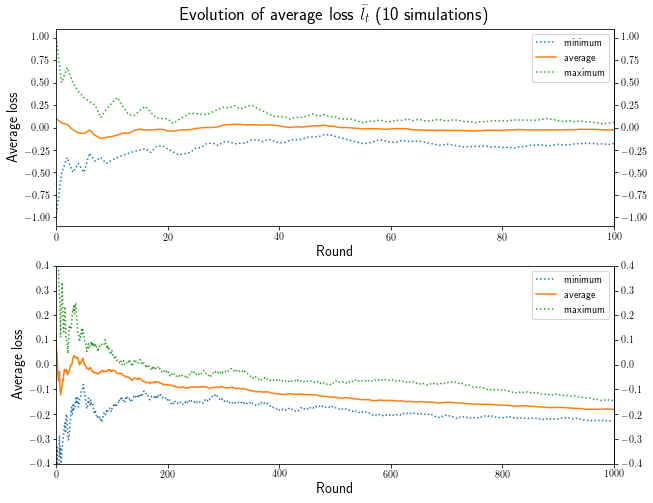

In [34]:
plt.figure(figsize=(10, 8))

# Zoom on first 100 rounds
plt.subplot(2, 1, 1)
plt.plot(mean_loss.min(axis=1), ':', label='minimum')
plt.plot(mean_loss.mean(axis=1), label='average')
plt.plot(mean_loss.max(axis=1), ':', label='maximum')

plt.xlabel('Round', fontsize=14)
plt.ylabel('Average loss', fontsize=14)
plt.xlim(0, 100)
plt.legend()
plt.gca().secondary_yaxis('right')
plt.title(
    'Evolution of average loss $\\bar{l_t}$ (10 simulations)', fontsize=18)

# Show all 1000 rounds
plt.subplot(2, 1, 2)
plt.plot(mean_loss.min(axis=1), ':', label='minimum')
plt.plot(mean_loss.mean(axis=1), label='average')
plt.plot(mean_loss.max(axis=1), ':', label='maximum')

plt.xlabel('Round', fontsize=14)
plt.ylabel('Average loss', fontsize=14)
plt.xlim(0, n_rounds)
plt.ylim(-.4,.4)
plt.gca().secondary_yaxis('right')
plt.legend();

Still with $\eta = 0.05$, we see that the algorithm most often has not converged by the 100<sup>th</sup> iteration (mean loss is barely negative). By the end of the 1000<sup>th</sup> round, 
The algorithm seems to have failed to converge in some of these simulations that end-up with a slightly positive average loss, consistent with the **Rock** strategy.

The same is repeated below with ***&eta; = 1***

In [35]:
eta = 1
sim = Simulation(EXP3Strategy(eta, M), Strategy(q_t), L)
sim.simulate(n_rounds)

mean_loss = np.zeros((n_rounds, n_rpt))
for rpt in range(n_rpt):
    sim.simulate(n_rounds)
    mean_loss[:, rpt] = sim.mean_loss_1()

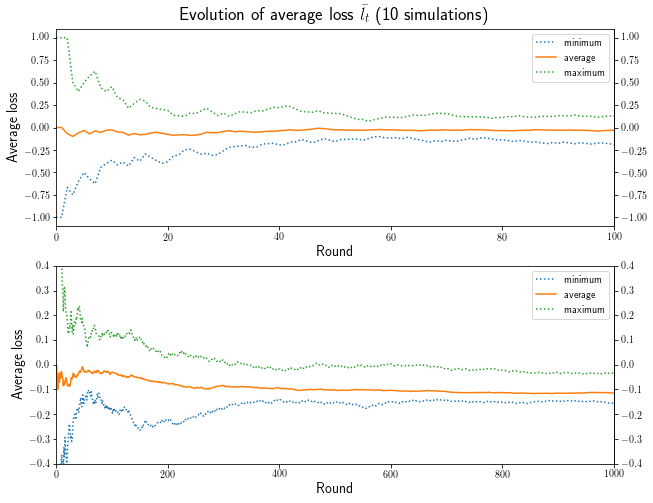

In [36]:
plt.figure(figsize=(10, 8))

# Zoom on first 100 rounds
plt.subplot(2, 1, 1)
plt.plot(mean_loss.min(axis=1), ':', label='minimum')
plt.plot(mean_loss.mean(axis=1), label='average')
plt.plot(mean_loss.max(axis=1), ':', label='maximum')

plt.xlabel('Round', fontsize=14)
plt.ylabel('Average loss', fontsize=14)
plt.xlim(0, 100)
plt.legend()
plt.gca().secondary_yaxis('right')
plt.title(
    'Evolution of average loss $\\bar{l_t}$ (10 simulations)', fontsize=18)

# Show all 1000 rounds
plt.subplot(2, 1, 2)
plt.plot(mean_loss.min(axis=1), ':', label='minimum')
plt.plot(mean_loss.mean(axis=1), label='average')
plt.plot(mean_loss.max(axis=1), ':', label='maximum')

plt.xlabel('Round', fontsize=14)
plt.ylabel('Average loss', fontsize=14)
plt.xlim(0, n_rounds)
plt.ylim(-.4,.4)
plt.gca().secondary_yaxis('right')
plt.legend();

Convergence eventually occurs, but this time there are still outliers pas round 200. At $t=1000$, the average loss is worse with $\eta=1$ than with $\eta=0.05$

*(f) Repeat one simulation for different values of learning rates $\eta \in \{0.01, 0.05, 0.1, 0.5, 1\}$ and plot the final
regret as a function of $\eta$. What are the best $\eta$ in practice and in theory?*

In order to repeat one simulation, the actions $j_t$ taken by player 2 are drawn once and will be shared among all simulations.  

In [37]:
#all_eta = [0.01, 0.05, 0.1, 0.5, 1]
all_eta = np.logspace(-2, 0, 11)

n_rounds = 1000

round_to_log =[100, 200, 500] + [n_rounds]
regret = np.zeros((len(all_eta), len(round_to_log)))

# The object will be re-used so that player 2 always plays the same actions
rpt_strategy = RepeatableStrategy(q_t)

for n_sim, eta in enumerate(all_eta):
    sim = Simulation(EXP3Strategy(eta, M), rpt_strategy, L)
    sim.simulate(n_rounds)
    regret[n_sim, :] = sim.cumul_regret_1()[np.array(round_to_log)-1]

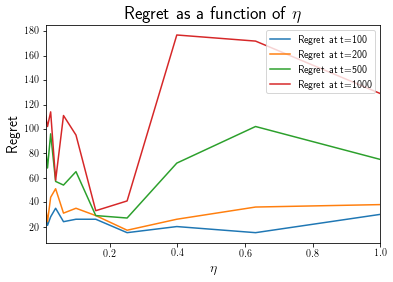

In [38]:
# Plot regret

for ii,rnd in enumerate(round_to_log):
    plt.plot(all_eta, regret[:,ii], label='Regret at t=%d'%rnd)

plt.xlabel('$\eta$', fontsize=14)
plt.ylabel('Regret', fontsize=14)
plt.title('Regret as a function of $\\eta$', fontsize=18)
plt.xlim(min(all_eta), max(all_eta))
plt.legend();

In [39]:
# optimal eta
for ii,rnd in enumerate(round_to_log + [n_rounds]):
    print('Optimal eta for %d rounds : %.3f'%(rnd,np.sqrt(np.log(M)/rnd)))

Optimal eta for 100 rounds : 0.105
Optimal eta for 200 rounds : 0.074
Optimal eta for 500 rounds : 0.047
Optimal eta for 1000 rounds : 0.033
Optimal eta for 1000 rounds : 0.033


The optimal value for $\eta$ with $T=100$ is given by $\eta = \sqrt{\frac{\log(K)}{T}} = 0.11$.

It is observed that the regret seems lowest for values of $\eta$ around 0.2. There is still a significant difference between the regret at $t=500$ and $t=1000$, indicating that the algorithm had not converged to pure **Paper** strategy at $t=500$ for any of values of $\eta$ 

In [40]:
# Compute regret over several simulations:

n_rpt = 36
regret = np.zeros((len(all_eta), n_rpt,  len(round_to_log)))

for rpt in range(n_rpt):
    # A new set of actions for player 2 is drawn and used for all eta
    rpt_strategy = RepeatableStrategy(q_t)

    for n_sim, eta in enumerate(all_eta):
        exp3 = EXP3Strategy(eta, M)
        sim = Simulation(exp3, rpt_strategy, L)
        sim.simulate(n_rounds)
        regret[n_sim, rpt, :] = sim.cumul_regret_1()[np.array(round_to_log)-1]

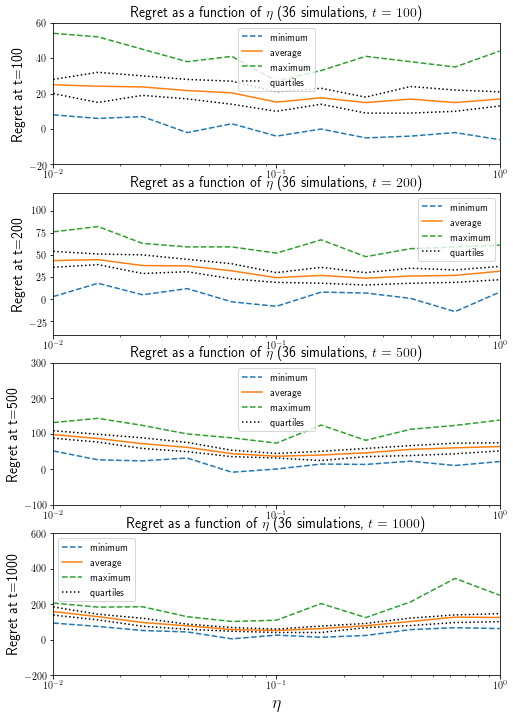

In [41]:
# Plot regret min/max/mean/quartiles
regret.sort(axis=1)
plt.figure(figsize=(8, 3*len(round_to_log)))

for ii, rnd in enumerate(round_to_log):
    reg = regret[:, :, ii]

    plt.subplot(len(round_to_log), 1, ii+1)
    plt.semilogx(all_eta, reg[:, 0], '--', label='minimum')
    plt.semilogx(all_eta, reg.mean(axis=1), label='average')
    plt.semilogx(all_eta, reg[:, -1], '--', label='maximum')
    plt.semilogx(all_eta, reg[:, np.floor(
        n_rpt/4).astype('int')], ':k', label='quartiles')
    plt.legend()
    plt.semilogx(all_eta, reg[:, np.ceil(3*n_rpt/4).astype('int')], ':k')

    plt.xlim(min(all_eta), max(all_eta))
    plt.ylim(-rnd*.2,rnd*.6)
    plt.ylabel('Regret at t=%d' % rnd, fontsize=14)
    plt.title('Regret as a function of $\\eta$ (%d simulations, $t=%d$)' %
              (n_rpt, rnd), fontsize=14)
    if ii==len(round_to_log)-1:
        plt.xlabel('$\eta$', fontsize=18)


The simulation is repeated 36 times and the regret at rounds 100, 200, 500 and 1000 plot with a consistent vertical scale.

At $t=100$ simulations, we see that the algorithm is quite unstable, with large variations of the regret depending on the simulation. The maximum and minimum regret are far apart from the average, although the quartiles are not so far apart. This means that, while at least half of the simulations ended-up with similar regrets, there are some outliers with much different values.

As the number of rounds increase, we see that some stability appears, with no more outliers except for higher values of $\eta$. Also, the optimum values of $\eta$ for which the regret is the lowest decreases, from $0.5$ at $t=100$, $0.2$ at $t=200$ and $0.1$ at $t=500$ and $t=1000$.

### Question 7
*7. Simulation against an adaptive adversary. Repeat the simulation of question 3) when the adversary is also playing EWA with learning parameters $\eta = 0.05$.*

*(a) Plot $\frac{1}{t} \sum^t_{s=1}l(i_s , j_s)$ as a function of $t$.*

*It is possible to show that if both players play according to a regret minimizing strategy the cumulative loss of the player converges to the value of the game:*
$$V = \min_{p \in \Delta_M} \max_{q \in \Delta_N} p^TLq$$

The simulation is staged with two players following the EXP3 algorithm, with $\eta_1 = 0.2$ and $\eta_2=0.05$. Higher values of $\eta$ are avoided as they may give way to instabilities, as seen in the previous question.

In [42]:
# Run the simulation against itself
n_rounds = 2000
eta_1 = .2
eta_2 = .05

sim = Simulation(EXP3Strategy(eta_1, M), EXP3Strategy(eta_2, N), L)
sim.simulate(n_rounds)

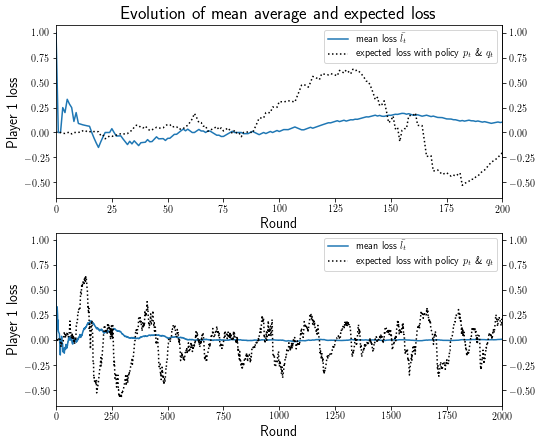

In [43]:
# Plot l_bar
plt.figure(figsize=(8, 7))

plt.subplot(2, 1, 1)
plt.plot(sim.mean_loss_1(), label='mean loss $\\bar{l_t}$')
plt.plot(sim.exp_loss_1(), ':k',
         label='expected loss with policy $p_t$ \& $q_t$')
plt.legend()

plt.xlabel('Round', fontsize=14)
plt.ylabel('Player 1 loss', fontsize=14)
plt.xlim(0, 200)
plt.title('Evolution of mean average and expected loss', fontsize=18)
plt.gca().secondary_yaxis('right')

# Second plot extended until round 2000
plt.subplot(2, 1, 2)
plt.plot(sim.mean_loss_1(), label='mean loss $\\bar{l_t}$')
plt.plot(sim.exp_loss_1(), ':k',
         label='expected loss with policy $p_t$ \& $q_t$')
plt.legend()

plt.xlabel('Round', fontsize=14)
plt.ylabel('Player 1 loss', fontsize=14)
plt.xlim(0, 2000)
plt.gca().secondary_yaxis('right');

As seen with EWA in the full information case, there are oscillations as strategies adapt to each other, resulting in draw in the long run: the mean loss remains close to zero, as neither strategy managed to get a long-lasting advantage over the other one.
The evolution of the strategies are plotted below:

(-0.05, 1.05)

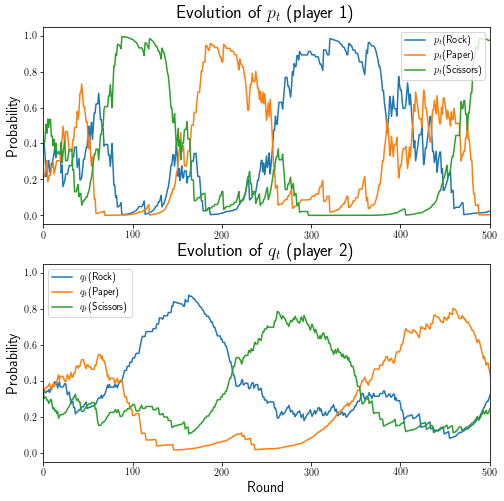

In [44]:
# Plot p_t and q_t
plt.figure(figsize=(8, 8))

# Player 1
plt.subplot(2, 1, 1)
for ii in range(M):
    plt.plot(sim.log_pt[:, ii], label='$p_t$({})'.format(actions[ii]))

# plt.xlabel("Round",fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.title("Evolution of $p_t$ (player 1)", fontsize=18)
plt.xlim(0, 500)
plt.ylim(-.05, 1.05)

# Player 2
plt.subplot(2, 1, 2)
for ii in range(M):
    plt.plot(sim.log_qt[:, ii], label='$q_t$({})'.format(actions[ii]))

plt.xlabel("Round", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend()
plt.title("Evolution of $q_t$ (player 2)", fontsize=18)
plt.xlim(0, 500)
plt.ylim(-.05, 1.05)

As expected, player 1 shows fast oscillations due to a higher learning rate, while player 2 has smoother variations in its policy.

---
*(b) Define $\bar{p_t} = \frac{1}{t}\sum_{s=1}p_s$. Plot in log log scale $\Vert \bar{p_t} - (1/3, 1/3, 1/3)\Vert_2$ as a function of $t$.*


Below are 4 plot with the evolution of average strategies $\bar{p_t}$ and $\bar{q_t}$, and distances to equilibrium $\Vert \bar{p_t} - (1/3, 1/3, 1/3)\Vert_2$ and $\Vert \bar{q_t} - (1/3, 1/3, 1/3)\Vert_2$.

The game fails to converge towards the Nash equilibrium, as both players adopt a strategy where **Rock** is always played. The average payout for the players is 0, the same as what they would get with the equiprobable strategies from the Nash equilibrium.

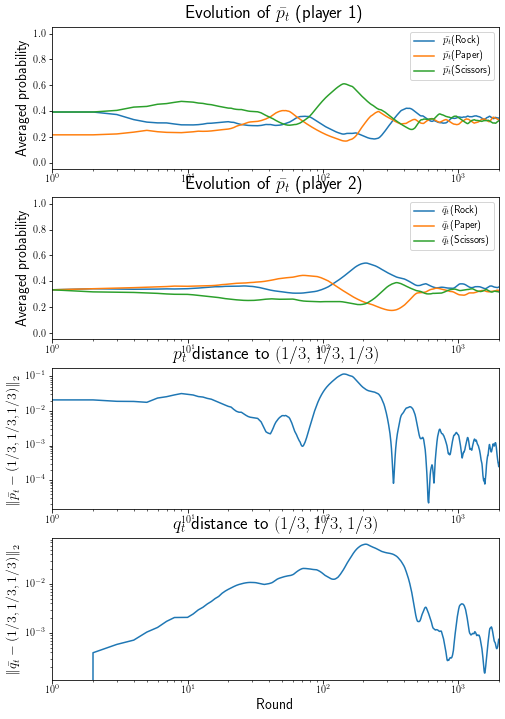

In [45]:
# Plot the average strategies
# Plot their distance to the Nash equilibrium

plt.figure(figsize=(8, 12))

p_bar = sim.mean_pt()
q_bar = sim.mean_qt()
p_dist = ((p_bar - np.ones((1, 3))/3)**2).sum(axis=1)
q_dist = ((q_bar - np.ones((1, 3))/3)**2).sum(axis=1)

# Evolution of p_bar
plt.subplot(4, 1, 1)
for ii in range(p_bar.shape[1]):
    plt.semilogx(1+np.arange(n_rounds),
                 p_bar[:, ii],
                 label='$\\bar{p_t}$(%s)' % format(actions[ii]))

# plt.xlabel("Round",fontsize=14)
plt.ylabel("Averaged probability", fontsize=14)
plt.legend()
plt.title("Evolution of $\\bar{p_t}$ (player 1)", fontsize=18)
plt.xlim(1, n_rounds)
plt.ylim(-.05, 1.05)

# Evolution of q_bar
plt.subplot(4, 1, 2)
for ii in range(q_bar.shape[1]):
    plt.semilogx(1+np.arange(n_rounds),
                 q_bar[:, ii],
                 label='$\\bar{q_t}$(%s)' % format(actions[ii]))

# plt.xlabel("Round",fontsize=14)
plt.ylabel("Averaged probability", fontsize=14)
plt.legend()
plt.title("Evolution of $\\bar{p_t}$ (player 2)", fontsize=18)
plt.xlim(1, n_rounds)
plt.ylim(-.05, 1.05)


# Evolution of p_dist
plt.subplot(4, 1, 3)
plt.loglog(1+np.arange(n_rounds), p_dist)

# plt.xlabel("Round",fontsize=14)
plt.ylabel("$\\Vert \\bar{p_t} - (1/3, 1/3, 1/3)\\Vert_2$", fontsize=14)
plt.title("$p_t$ distance to $(1/3,1/3,1/3)$", fontsize=18)
plt.xlim(1, n_rounds)

# Evolution of q_dist
plt.subplot(4, 1, 4)
plt.loglog(1+np.arange(n_rounds), q_dist)

plt.xlabel("Round", fontsize=14)
plt.ylabel("$\\Vert \\bar{q_t} - (1/3, 1/3, 1/3)\\Vert_2$", fontsize=14)
plt.title("$q_t$ distance to $(1/3,1/3,1/3)$", fontsize=18)
plt.xlim(1, n_rounds);

As in the EWA case, the strategies eventually converge, on average, to the Nash equilibrium policy. There also seem to be a linear upper-bound on the log-log plot, i.e. an exponential decrease of the distance between average and equilibrium policies over time.

---
### Question 8
*8. Repeat Question 4.a) when the adversary is playing a* **UCB** *algorithm. Who wins between* **UCB** *and* **EXP3**?*

It should be noted that **UCB** is designed for independant and identically distributed rewards, for each action. This is not the case here, as the adversary will try to adapt and change its strategy over time.

There is an exploratory phase (longer as parameter $c$ increases), but once a few rounds have passed, the algorithm will do only exploitation and behave as a greedy algorithm that pick the strategy that produced the highest cumulative reward. Such algorithm only changes strategy when all accumulated rewards that have been earned using that strategy have been lost, to the point where alternatives strategies have a better track record.

However, **EXP3** strategies suffer from the same problem: the longer a strategy has been working against an opponent, the lower the probability that alternate strategies are played (down to 1e-4, 1e-5, etc). If suddenly the adversay adapts, then it will take an equally long time playing the same strategy _ now a losing one _ for the probabilities of alternate strategies to increase back to the point where they may be actually played ans a switch may occur.

In the long run, these behaviors cancel out: both strategies will lose as much as thay have gained once the adversary has adapted. **The simulation ends-up in a draw over time.**

In [46]:
class UCBStrategy(BanditStrategy):
    """
    UCB algorithm is as follow:
    
    Set R,N,Q to null vectors
    Set t=0

    Loop:
        Pick action k = arg max [Q(k) + c sqrt(log(t)/N(k))]
        Receive reward X
        N(k) <-- N(k) + 1
        R(k) <-- R(k) + X
        Q(k) <-- R(k) / N(k)
    """

    def __init__(self, c, N):
        self.c = c
        self.N = N

        self.reset()

    def reset(self):
        self.proba = np.ones(self.N)/self.N

        # Time, reward and count vectors
        self.t = 0
        self.cnt = np.zeros(self.N)
        self.R = np.zeros(self.N)

    def _bandit_update(self, loss, my_action):
        reward = (1-loss)*.5

        self.t += 1
        self.cnt[my_action] += 1
        self.R[my_action] += reward

        if (self.cnt == 0).any():
            # Actions never chosen have equal probability
            p = (self.cnt == 0).astype('float')
        else:
            # Action with highest adjusted Q have equal probability
            Q = self.R / self.cnt + self.c * np.sqrt(np.log(self.t)/self.cnt)
            p = (Q == Q.max()).astype('float')

        # normalize
        self.proba = p / p.sum()

In [47]:
# Simulation
n_rounds = 2000
eta_1 = .1
c = 1

sim = Simulation(EXP3Strategy(eta_1, M), UCBStrategy(c, N), L)
#sim = Simulation(Strategy([.5,.25,.25]), UCBStrategy(c,N) ,L)
sim.simulate(n_rounds)

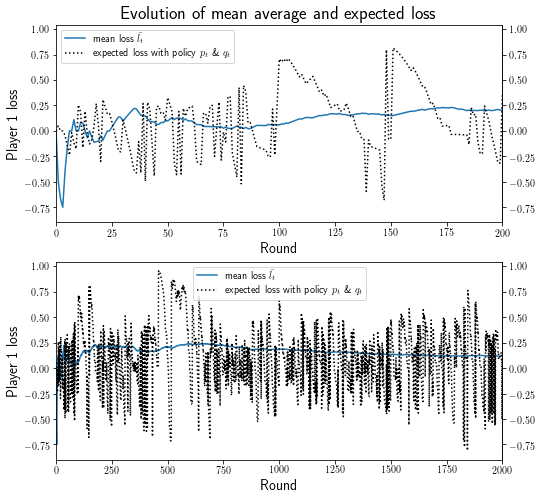

In [48]:
# Plot average loss l_bar

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(sim.mean_loss_1(), label='mean loss $\\bar{l_t}$')
plt.plot(sim.exp_loss_1(), ':k',
         label='expected loss with policy $p_t$ \& $q_t$')
plt.legend()

plt.xlabel('Round', fontsize=14)
plt.ylabel('Player 1 loss', fontsize=14)
plt.xlim(0, 200)
plt.title('Evolution of mean average and expected loss', fontsize=18)
plt.gca().secondary_yaxis('right')

# Second plot extended until round 2000
plt.subplot(2, 1, 2)
plt.plot(sim.mean_loss_1(), label='mean loss $\\bar{l_t}$')
plt.plot(sim.exp_loss_1(), ':k',
         label='expected loss with policy $p_t$ \& $q_t$')
plt.legend()

plt.xlabel('Round', fontsize=14)
plt.ylabel('Player 1 loss', fontsize=14)
plt.xlim(0, 2000)
plt.gca().secondary_yaxis('right');

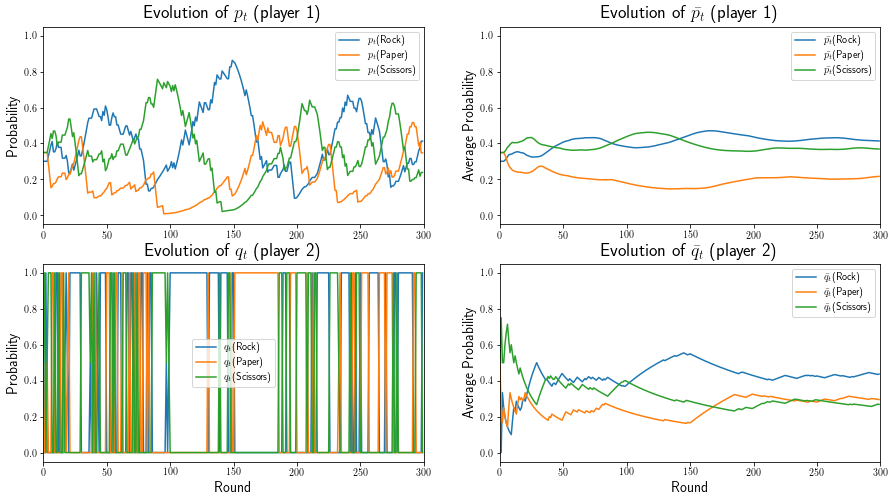

In [49]:
# Plot strategies p_t and q_t

plt.figure(figsize=(15, 8))
n_shown = 300
# Player 1
plotdata = [[sim.log_pt, sim.mean_pt()],[sim.log_qt, sim.mean_qt()]]
for pp, label in enumerate(['p_t', 'q_t']):
    label_bar = '\\bar{%s}'%label
    for qq, full_label in enumerate([label, label_bar]):
        plt.subplot(2, 2, 2*pp+qq+1)
        for ii in range(M):
            plt.plot(plotdata[pp][qq][:n_shown, ii], label='${}$({})'.format(full_label,actions[ii]))

        if pp==1:
            plt.xlabel("Round", fontsize=14)
        plt.ylabel(("Average "if qq==1 else "")+"Probability", fontsize=14)
        plt.legend()
        plt.title("Evolution of $%s$ (player %d)"%(full_label,pp+1), fontsize=18)
        plt.xlim(0, n_shown)  
        plt.ylim(-.05,1.05);

---
### Question 9
*9. In this lecture, we saw that* **EXP3** *has a sublinear expected regret. Yet, as shown by question 6.e), it is extremely unstable with a large variance. Implement* **EXP3.IX** *(see Chapter 12 of [1]) a modification of* **EXP3** *that controls the regret in expectation and simultaneously keeps it stable. Repeat question 3.e) with* **EXP3.IX**



The **EXP3.IX** strategy has already been implmented in class ***EXP3Strategy***

In [50]:
eta = 1
gamma = 1

n_rounds=1000
sim = Simulation(EXP3Strategy(eta, M, .5), Strategy(q_t), L)
sim.simulate(n_rounds)

mean_loss = np.zeros((n_rounds, n_rpt))
for rpt in range(n_rpt):
    sim.simulate(n_rounds)
    mean_loss[:, rpt] = sim.mean_loss_1()

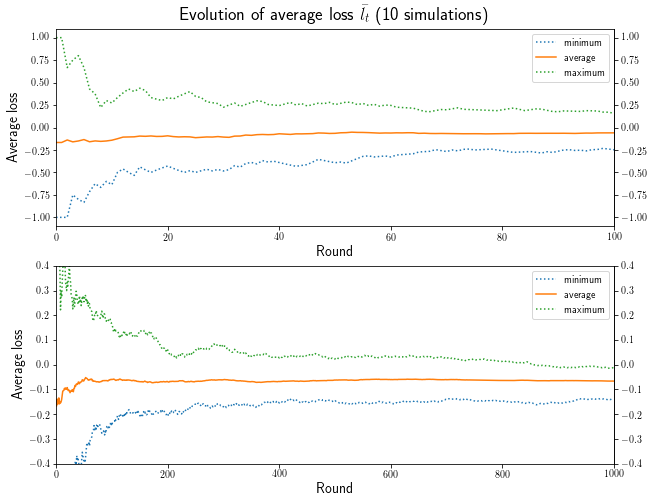

In [51]:
plt.figure(figsize=(10, 8))

# Zoom on first 100 rounds
plt.subplot(2, 1, 1)
plt.plot(mean_loss.min(axis=1), ':', label='minimum')
plt.plot(mean_loss.mean(axis=1), label='average')
plt.plot(mean_loss.max(axis=1), ':', label='maximum')

plt.xlabel('Round', fontsize=14)
plt.ylabel('Average loss', fontsize=14)
plt.xlim(0, 100)
plt.legend()
plt.gca().secondary_yaxis('right')
plt.title(
    'Evolution of average loss $\\bar{l_t}$ (10 simulations)', fontsize=18)

# Show all 1000 rounds
plt.subplot(2, 1, 2)
plt.plot(mean_loss.min(axis=1), ':', label='minimum')
plt.plot(mean_loss.mean(axis=1), label='average')
plt.plot(mean_loss.max(axis=1), ':', label='maximum')

plt.xlabel('Round', fontsize=14)
plt.ylabel('Average loss', fontsize=14)
plt.xlim(0, n_rounds)
plt.ylim(-.4,.4)
plt.gca().secondary_yaxis('right')
plt.legend();

There is no clear difference compared to what had been obtained with **EXP3**. It even seems worse. To better understand what happens, a batch of simulations is done with different values of $\eta$, comaring **EXP3** with **EXP.IX** run with different values of $\gamma$

In [52]:
# Compute regret over several simulations:
import multiprocessing as mp

# Set parameters
n_cpu = 6
n_rounds = 1000
n_rpt = 100

round_to_log =[50, 100, 200, 500] + [n_rounds]
all_eta = np.logspace(-2, .5, 12)
all_gamma = [.1,.5,1]

#regret = np.zeros((len(all_eta), n_rpt,  len(round_to_log)))
#regret_ix = np.zeros((len(all_eta), n_rpt,  len(round_to_log), len(all_gamma)))
 
    
def custom_sim(dummy):
    # The function contains on repetition of the simulations for all strategies and for all eta
    
    # Player 2 will take the same actions for all the simulations
    rpt_strategy = RepeatableStrategy(q_t)
    
    # Initialize regret array
    tmp_regret = np.zeros((len(all_eta), 1,  len(round_to_log)))
    tmp_regret_ix = np.zeros((len(all_eta), 1,  len(round_to_log), len(all_gamma)))

    for n_sim, eta in enumerate(all_eta):
        # Simulation with EXP3
        exp3 = EXP3Strategy(eta, M)
        sim = Simulation(exp3, rpt_strategy, L)
        sim.simulate(n_rounds)
        tmp_regret[n_sim, 0, :] = sim.cumul_regret_1()[np.array(round_to_log)-1]
        
        # Simulations with all EXP.IX
        for jj,gamma in enumerate(all_gamma):
            exp3ix = EXP3Strategy(eta, M,gamma)
            sim = Simulation(exp3ix, rpt_strategy, L)
            sim.simulate(n_rounds)
            tmp_regret_ix[n_sim, 0, :, jj] = sim.cumul_regret_1()[np.array(round_to_log)-1]

    return (tmp_regret,tmp_regret_ix)

# Run the simulations in parallel. There are many of them and many rounds, so will run a bit faster
parallel_result = mp.Pool(n_cpu).map(custom_sim, range(n_rpt))

# Extract the regret vectors from the simulation result
regret = np.concatenate([res[0] for res in parallel_result],axis=1)
regret_ix = np.concatenate([res[1] for res in parallel_result],axis=1)

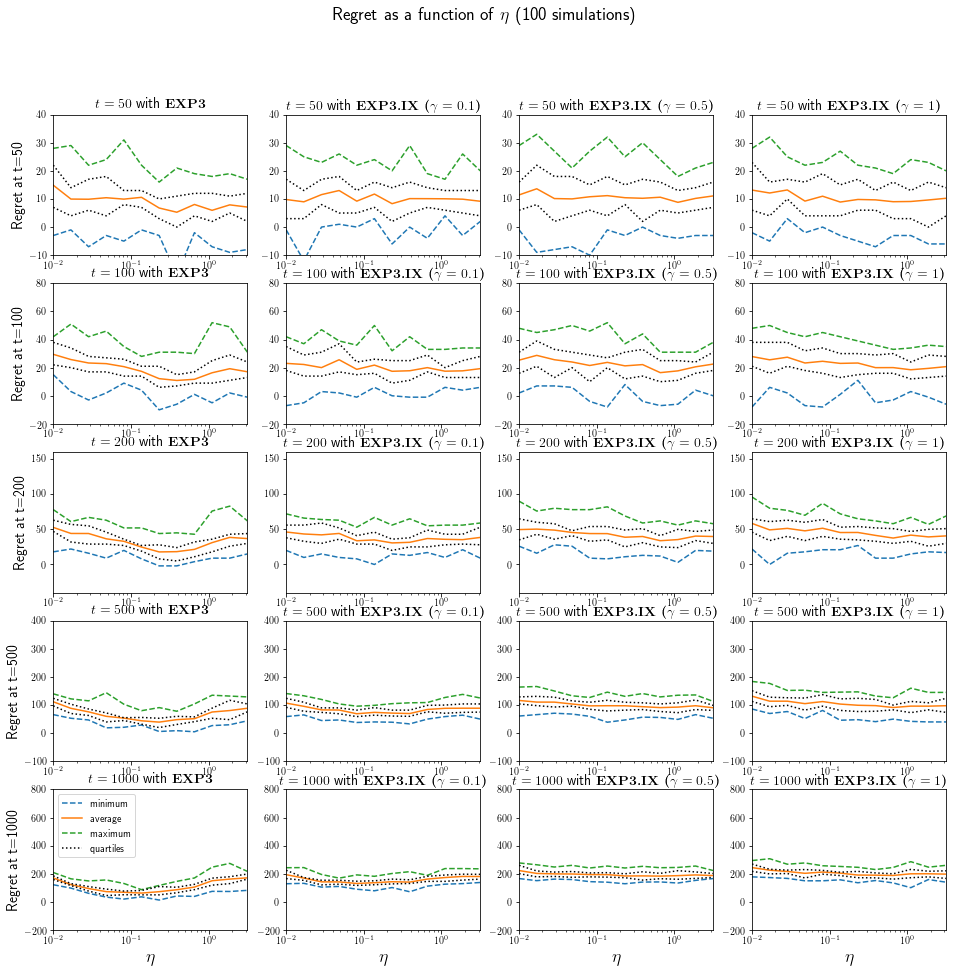

In [53]:
# Plot regret min/max/mean/quartiles
regret.sort(axis=1)
regret_ix.sort(axis=1)
plt.figure(figsize=(16, 3*len(round_to_log)))

for ii, rnd in enumerate(round_to_log):
    all_regret = [regret[:, :, ii]] + \
        [regret_ix[:, :, ii, jj] for jj in range(regret_ix.shape[3])]
    all_labels = ['EXP3'] + \
        [f'EXP3.IX ($\\gamma = {gamma}$)' for gamma in all_gamma]

    for jj, (reg, reg_label) in enumerate(zip(all_regret, all_labels)):

        plt.subplot(len(round_to_log), len(
            all_regret), len(all_regret)*ii+jj+1)
        plt.semilogx(all_eta, reg[:, 0], '--', label='minimum')
        plt.semilogx(all_eta, reg.mean(axis=1), label='average')
        plt.semilogx(all_eta, reg[:, -1], '--', label='maximum')
        plt.semilogx(all_eta, reg[:, np.floor(
            n_rpt/4).astype('int')], ':k', label='quartiles')
        plt.semilogx(all_eta, reg[:, np.ceil(3*n_rpt/4).astype('int')], ':k')

        plt.xlim(min(all_eta), max(all_eta))
        plt.ylim(-rnd*.2, rnd*.8)
        if jj == 0:
            plt.ylabel('Regret at t=%d' % rnd, fontsize=14)
        if ii == len(round_to_log)-1:
            plt.xlabel('$\eta$', fontsize=18)
            if jj == 0:
                plt.legend(loc='upper left')
        plt.title('$t=%d$ with \\bf{%s}' %
                  (rnd, reg_label), fontsize=14)
plt.suptitle('Regret as a function of $\\eta$ (%d simulations)' %
             n_rpt, fontsize=18);

The *EXP3.IX* strategy seems to be slightly more stable at the beginning: at $t=100$ and $t=200$, there seem to be less outliers with *EXP3.IX* for $\gamma = 0.5$ or $\gamma = 1$ than with *EXP3*. For larger values of $\eta$, some simulations with *EXP3* resulted in a much higher than average regret. This is not the case with *EXP3.IX*.

However, at $t=1000$, simulations with *EXP3.IX* simulations have all resulted in a larger regret than thos with *EXP3*. There is perhaps still an increase of stability for larger values of $\eta$, but this is not the case for values of $\eta$ around $0.1$ where $EXP3$ has the best performance.

Given sufficient time, *EXP3* seems to best *EXP3.IX$.

---
### Question 10:
*10. Try different games (not necessarily zero-sum games). In particular, how these algorithms behave for the
prisoner’s dilemna (see wikipedia)? The prisoner’s dilemna is a two-player games that shows why two completely
rational individuals might not cooperate, even if it appears that it is in their best interests to do so.*

EWA and EXP3 will be tested for a few other games:
- Rock, Parper, Scissors & Well variant
- Prisoniers dilemma

In both cases, EWA and EXP (with &eta;=0.1) will be run over 1000 rounds, and the game and strategies compared.

#### Rock, Paper, Scissors and Well variant
The Well loses against Paper and wins against Rock & Scissors. The Nash equilibrium for the game is $p_t = (0, 1/3, 1/3, 1/3)$

The loss matrix for the player is:

$$L = \left[
\begin{array}{cccc}
 0 &  1 & -1 &  1\\
-1 &  0 &  1 & -1\\
 1 & -1 &  0 &  1\\
-1 &  1 & -1 &  0
\end{array}
\right]
\begin{array}{l}
\text{Rock}\\
\text{Paper}\\
\text{Scissor}\\
\text{Well}
\end{array}$$


#### EWA

Player 1 : EXP3 with $\eta=1$ - Player 2 : EXP3 with $\eta=.1$

In [54]:
L_rpsw = np.array([[0, 1, -1, 1], [-1, 0, 1, -1], [1, -1, 0, 1], [-1, 1, -1, 0]])
M, N = L_rpsw.shape
actions = ['Rock', 'Paper', 'Scissors', 'Well']
n_rounds = 1000

# player 1 strategy
stat_p1 = EWAStrategy(1, M)
# player 2 strategy
strat_p2 = EWAStrategy(.1, M)

# Run simulation
sim = Simulation(stat_p1, strat_p2, L_rpsw)
sim.simulate(n_rounds)

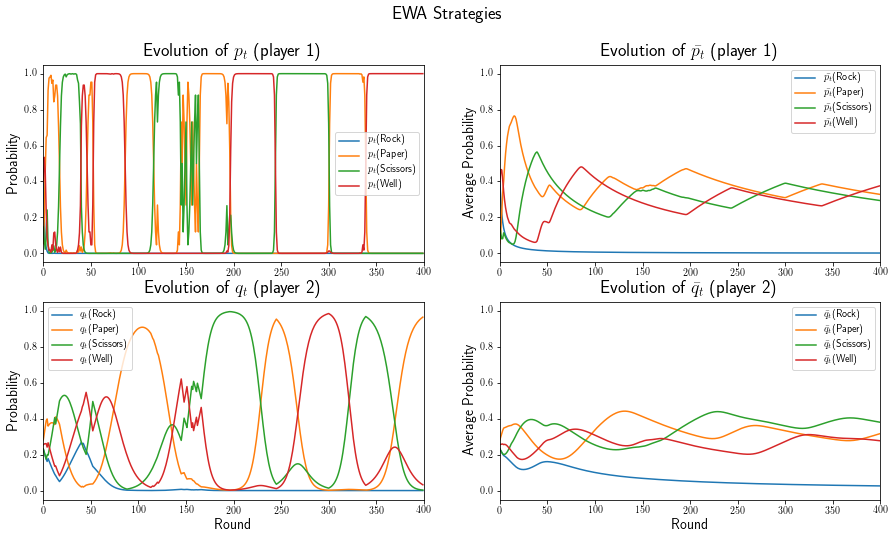

In [55]:
# Plot strategies p_t and q_t

plt.figure(figsize=(15, 8))
n_shown = 400
# Player 1
plotdata = [[sim.log_pt, sim.mean_pt()],[sim.log_qt, sim.mean_qt()]]
for pp, label in enumerate(['p_t', 'q_t']):
    label_bar = '\\bar{%s}'%label
    for qq, full_label in enumerate([label, label_bar]):
        plt.subplot(2, 2, 2*pp+qq+1)
        for ii in range(M):
            plt.plot(plotdata[pp][qq][:n_shown, ii], label='${}$({})'.format(full_label,actions[ii]))

        if pp==1:
            plt.xlabel("Round", fontsize=14)
        plt.ylabel(("Average "if qq==1 else "")+"Probability", fontsize=14)
        plt.legend()
        plt.title("Evolution of $%s$ (player %d)"%(full_label,pp+1), fontsize=18)
        plt.xlim(0, n_shown)  
        plt.ylim(-.05,1.05);
plt.suptitle('EWA Strategies',fontsize=18);

#### EXP3

Player 1 : EXP3 with $\eta=1$ - Player 2 : EXP3 with $\eta=.1$

In [56]:
# player 1 strategy
stat_p1 = EXP3Strategy(1, M)
# player 2 strategy
strat_p2 = EXP3Strategy(.1, M)

# Run simulation
sim = Simulation(stat_p1, strat_p2, L_rpsw)
sim.simulate(n_rounds)

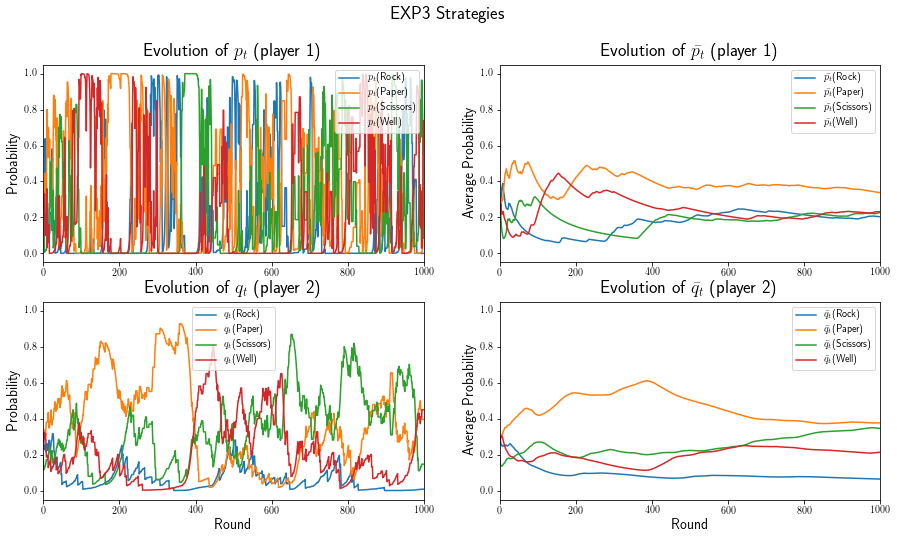

In [57]:
# Plot strategies p_t and q_t

plt.figure(figsize=(15, 8))
n_shown = 1000
# Player 1
plotdata = [[sim.log_pt, sim.mean_pt()],[sim.log_qt, sim.mean_qt()]]
for pp, label in enumerate(['p_t', 'q_t']):
    label_bar = '\\bar{%s}'%label
    for qq, full_label in enumerate([label, label_bar]):
        plt.subplot(2, 2, 2*pp+qq+1)
        for ii in range(M):
            plt.plot(plotdata[pp][qq][:n_shown, ii], label='${}$({})'.format(full_label,actions[ii]))

        if pp==1:
            plt.xlabel("Round", fontsize=14)
        plt.ylabel(("Average "if qq==1 else "")+"Probability", fontsize=14)
        plt.legend()
        plt.title("Evolution of $%s$ (player %d)"%(full_label,pp+1), fontsize=18)
        plt.xlim(0, n_shown)  
        plt.ylim(-.05,1.05);
plt.suptitle('EXP3 Strategies',fontsize=18);

#### EXP3.IX

Player 1 : EXP3 with $\eta=1, \gamma=.5$ - Player 2 : EXP3 with $\eta=.1, \gamma=.5$

In [58]:
# player 1 strategy
stat_p1 = EXP3Strategy(1, M, .5)
# player 2 strategy
strat_p2 = EXP3Strategy(.1, M, .5)

# Run simulation
sim = Simulation(stat_p1, strat_p2, L_rpsw)
sim.simulate(n_rounds)

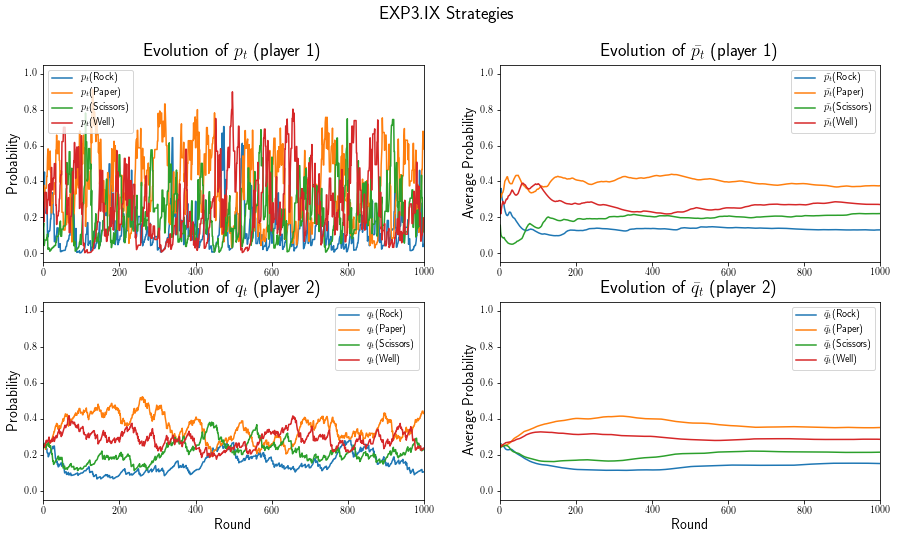

In [59]:
# Plot strategies p_t and q_t

plt.figure(figsize=(15, 8))
n_shown = 1000
# Player 1
plotdata = [[sim.log_pt, sim.mean_pt()],[sim.log_qt, sim.mean_qt()]]
for pp, label in enumerate(['p_t', 'q_t']):
    label_bar = '\\bar{%s}'%label
    for qq, full_label in enumerate([label, label_bar]):
        plt.subplot(2, 2, 2*pp+qq+1)
        for ii in range(M):
            plt.plot(plotdata[pp][qq][:n_shown, ii], label='${}$({})'.format(full_label,actions[ii]))

        if pp==1:
            plt.xlabel("Round", fontsize=14)
        plt.ylabel(("Average "if qq==1 else "")+"Probability", fontsize=14)
        plt.legend()
        plt.title("Evolution of $%s$ (player %d)"%(full_label,pp+1), fontsize=18)
        plt.xlim(0, n_shown)  
        plt.ylim(-.05,1.05);
plt.suptitle('EXP3.IX Strategies',fontsize=18);

We notice:
- **EWA** strategies quickly converge to an oscillating state which, on average, follow the Nash equilibrium policy
- **EXP3** with $\eta=0.1$ (player 2) slowly converge towards the equilibrium. EXP3 with $\eta=1$ suffers from fast oscillations and has not converged on average towards the Nash equilibrium policy. In particular, it has failed to eliminate the action **Rock** from its policy by the 1000<sup>th</sup> round
- **EXP3.IX** behaves more or less as **EXP3**. Its policy never completely eliminate an action, and a pure policy is never used (for all action, $p_t$ and $q_t$ never $0.0$ or $1.0$). There is always some amount of **Rock** in the policies, until the end. Actually, it seems that EXP3.IX algorithm has some exploration behavior that never stops.

### Prisonnier's dilemma
The loss matrix is asymetric:
$$L = \left[
\begin{array}{cc}
 (1,1) & (3,0)\\
 (0,3) & (2,2)
\end{array}
\right]
\begin{array}{l}
\text{Cooperate}\\
\text{Defect}
\end{array}$$


#### EWA

Player 1 : EXP3 with $\eta=1$ - Player 2 : EXP3 with $\eta=.1$

In [60]:
# Simulation of Rock, Paper, Scissors, Well
L_prisonnier = np.array([[1,3], [0,2]])
M, N = L_prisonnier.shape
actions = ['Cooperate', 'Defect']
n_rounds = 1000

# player 1 strategy
stat_p1 = EWAStrategy(1, M)
# player 2 strategy
strat_p2 = EWAStrategy(.1, M)

# Run simulation
sim = Simulation(stat_p1, strat_p2, L_prisonnier, L_prisonnier.T)
sim.simulate(n_rounds)

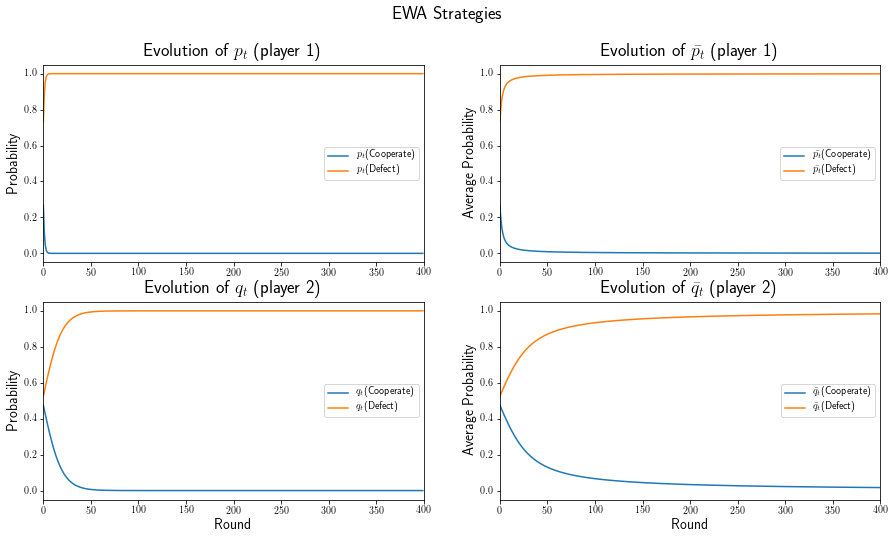

In [61]:
# Plot strategies p_t and q_t

plt.figure(figsize=(15, 8))
n_shown = 400
# Player 1
plotdata = [[sim.log_pt, sim.mean_pt()],[sim.log_qt, sim.mean_qt()]]
for pp, label in enumerate(['p_t', 'q_t']):
    label_bar = '\\bar{%s}'%label
    for qq, full_label in enumerate([label, label_bar]):
        plt.subplot(2, 2, 2*pp+qq+1)
        for ii in range(M):
            plt.plot(plotdata[pp][qq][:n_shown, ii], label='${}$({})'.format(full_label,actions[ii]))

        if pp==1:
            plt.xlabel("Round", fontsize=14)
        plt.ylabel(("Average "if qq==1 else "")+"Probability", fontsize=14)
        plt.legend()
        plt.title("Evolution of $%s$ (player %d)"%(full_label,pp+1), fontsize=18)
        plt.xlim(0, n_shown)  
        plt.ylim(-.05,1.05);
plt.suptitle('EWA Strategies',fontsize=18);

#### EXP3

Player 1 : EXP3 with $\eta=1$ - Player 2 : EXP3 with $\eta=.1$

In [62]:
# player 1 strategy
stat_p1 = EXP3Strategy(1, M)
# player 2 strategy
strat_p2 = EXP3Strategy(.1, M)

# Run simulation
sim = Simulation(stat_p1, strat_p2, L_prisonnier, L_prisonnier.T)
sim.simulate(n_rounds)

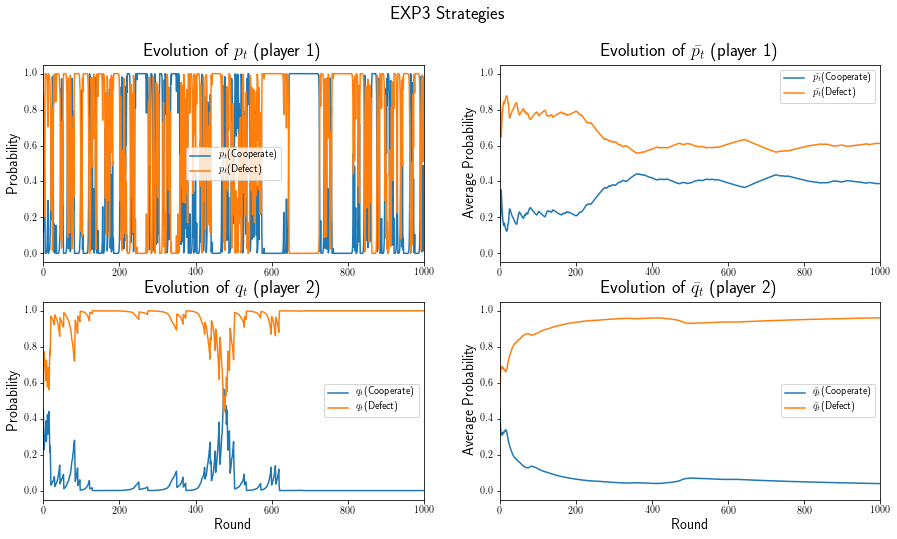

In [63]:
# Plot strategies p_t and q_t

plt.figure(figsize=(15, 8))
n_shown = 1000
# Player 1
plotdata = [[sim.log_pt, sim.mean_pt()],[sim.log_qt, sim.mean_qt()]]
for pp, label in enumerate(['p_t', 'q_t']):
    label_bar = '\\bar{%s}'%label
    for qq, full_label in enumerate([label, label_bar]):
        plt.subplot(2, 2, 2*pp+qq+1)
        for ii in range(M):
            plt.plot(plotdata[pp][qq][:n_shown, ii], label='${}$({})'.format(full_label,actions[ii]))

        if pp==1:
            plt.xlabel("Round", fontsize=14)
        plt.ylabel(("Average "if qq==1 else "")+"Probability", fontsize=14)
        plt.legend()
        plt.title("Evolution of $%s$ (player %d)"%(full_label,pp+1), fontsize=18)
        plt.xlim(0, n_shown)  
        plt.ylim(-.05,1.05);
plt.suptitle('EXP3 Strategies',fontsize=18);

#### EXP3.IX

Player 1 : EXP3 with $\eta=1, \gamma=.5$ - Player 2 : EXP3 with $\eta=.1, \gamma=.5$

In [64]:
# player 1 strategy
stat_p1 = EXP3Strategy(1, M, .5)
# player 2 strategy
strat_p2 = EXP3Strategy(.1, M, .5)

# Run simulation
sim = Simulation(stat_p1, strat_p2, L_prisonnier, L_prisonnier.T)
sim.simulate(n_rounds)

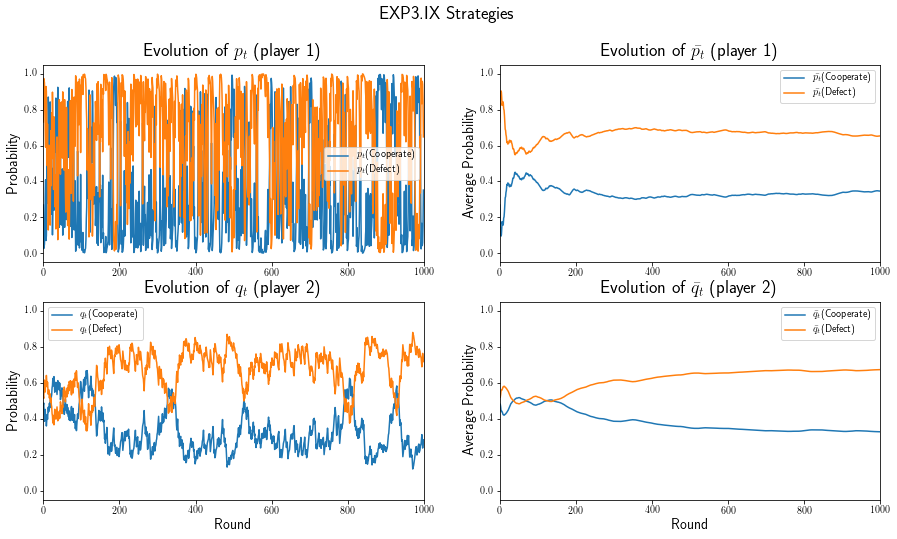

In [65]:
# Plot strategies p_t and q_t

plt.figure(figsize=(15, 8))
n_shown = 1000
# Player 1
plotdata = [[sim.log_pt, sim.mean_pt()],[sim.log_qt, sim.mean_qt()]]
for pp, label in enumerate(['p_t', 'q_t']):
    label_bar = '\\bar{%s}'%label
    for qq, full_label in enumerate([label, label_bar]):
        plt.subplot(2, 2, 2*pp+qq+1)
        for ii in range(M):
            plt.plot(plotdata[pp][qq][:n_shown, ii], label='${}$({})'.format(full_label,actions[ii]))

        if pp==1:
            plt.xlabel("Round", fontsize=14)
        plt.ylabel(("Average "if qq==1 else "")+"Probability", fontsize=14)
        plt.legend()
        plt.title("Evolution of $%s$ (player %d)"%(full_label,pp+1), fontsize=18)
        plt.xlim(0, n_shown)  
        plt.ylim(-.05,1.05);
plt.suptitle('EXP3.IX Strategies',fontsize=18);

We notice:
- **EWA** strategies quickly converge to the Nash equilibrium $(\text{Defect}, \text{Defect})$
- **EXP3** with $\eta=0.1$ (player 2) converges towards the equilibrium. EXP3 with $\eta=1$ fails to converge by the end of the simulation, even after the adversary has settled for a pure $\text{Defect}$ strategy. It is too unstable.
- **EXP3.IX** does not converge towards the equilibrium, but seem to converge toward a policy with a substatial proportion of cooperative behavior: a policy somewhere between the Nash equilibrium (pure *Defect*) and the equiprobable policy (50/50).